## Set up

Install required packages and load relevant data. Ensure you adjust to add relevant classifiers.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from joblib import dump
import pickle as pkl
import os
from imblearn.over_sampling import SMOTE 
## import required classifiers, preprocessing, etc.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
# Add additional as required

os.chdir(Path.cwd().parent)
# import custom files
from src.data import make_dataset
from src.data import submit_predictions
from src.visualization import visualize
#import misc visualisation and EDA packages
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns


In [2]:
os.chdir('notebooks')

### Set Directory paths

In [3]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

## Download and Prepare Data

In [4]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)

In [5]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')


In [6]:
X_test = pd.read_csv(raw_data_dir / 'test.csv')

In [7]:
df_train.drop(columns=['Id_old', 'Id'], inplace=True)
X_test.drop(columns=['Id_old'], inplace=True)
test_id = X_test.pop('Id')

## Split into Training and ValidationSet

In [8]:
target = 'TARGET_5Yrs'
X, y = make_dataset.separate_target(df_train, target=target)

## Modelling

## Base Model
The base model is the model from week 1

In [9]:
file_name = models_dir /'brackenrig_mark_12964298_week1_votingclassifier.sav'
baseline_model = pkl.load(open(file_name,'rb'))

In [10]:
baseline_model.best_params_

{'weights': [1, 3],
 'rf__classifier__n_estimators': 1000,
 'rf__classifier__max_features': 'log2',
 'rf__classifier__max_depth': 3,
 'rf__classifier__class_weight': 'balanced',
 'lr__classifier__penalty': 'l2'}

 class 1 :  6669
 class 0 :  1331
Confusion Matrix: 
 [[  99 1232]
 [  85 6584]]
Accuracy:  0.835375
AUC:  0.7125074593539142
              precision    recall  f1-score   support

           0       0.54      0.07      0.13      1331
           1       0.84      0.99      0.91      6669

    accuracy                           0.84      8000
   macro avg       0.69      0.53      0.52      8000
weighted avg       0.79      0.84      0.78      8000



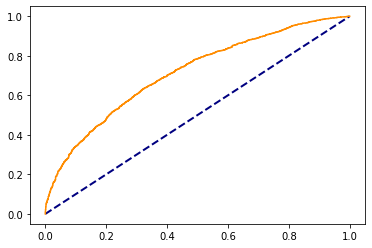

In [11]:
visualize.classification_reports(baseline_model,X,y)

# Include Synthetic Oversampling
Including SMOTE with no calibration may improve results by synthetically oversampling the minority class

In [12]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)


In [13]:
model = baseline_model

model.fit(X_sm, y_sm)

Fitting 7 folds for each of 12 candidates, totalling 84 fits


RandomizedSearchCV(cv=7,
                   estimator=VotingClassifier(estimators=[('rf',
                                                           Pipeline(steps=[('classifier',
                                                                            RandomForestClassifier(oob_score=True))])),
                                                          ('lr',
                                                           Pipeline(steps=[('scaler',
                                                                            StandardScaler()),
                                                                           ('pca',
                                                                            PCA()),
                                                                           ('classifier',
                                                                            LogisticRegression(max_iter=10000))]))],
                                              voting='soft'),
                  

### Inspect Results

 class 1 :  6669
 class 0 :  1331
Confusion Matrix: 
 [[ 791  540]
 [1887 4782]]
Accuracy:  0.696625
AUC:  0.7202794949641405
              precision    recall  f1-score   support

           0       0.30      0.59      0.39      1331
           1       0.90      0.72      0.80      6669

    accuracy                           0.70      8000
   macro avg       0.60      0.66      0.60      8000
weighted avg       0.80      0.70      0.73      8000



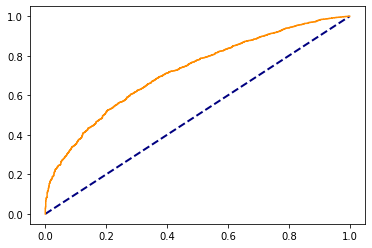

In [14]:
visualize.classification_reports(model,X,y)

In [15]:
submit_predictions.submit_predictions(model, X_test, test_id,"SMOTE model experiment- No calibration", pred_path=processed_data_dir/'12964298_week2_SMOTE_no_cal.csv')

Success! User is Authenticated


100%|██████████| 88.1k/88.1k [00:06<00:00, 13.6kB/s]


,id,TARGET_5Yrs
0,0,0.580874
1,1,0.432689
2,2,0.739632
3,3,0.812192
4,4,0.369429
...,...,...
3794,3794,0.861170
3795,3795,0.556160
3796,3796,0.411123
3797,3797,0.825889


## Calibration
As we can see, there is a minor improvement on the baseline model. Unfortunately the model is not calibrated, it expects that the minority class is more likely in the wild then it actually is. To get around this, using the `CalibratedClassifierCV` will retrain the model with calibration. Initially we will use the setting `cv='prefit'`, which does not retrain the model, but adjusts the probabilities to reflect the true data. 

In [16]:
calibration_no_refit = CalibratedClassifierCV(model, cv = 'prefit')
calibration_no_refit.fit(X,y)

CalibratedClassifierCV(base_estimator=RandomizedSearchCV(cv=7,
                                                         estimator=VotingClassifier(estimators=[('rf',
                                                                                                 Pipeline(steps=[('classifier',
                                                                                                                  RandomForestClassifier(oob_score=True))])),
                                                                                                ('lr',
                                                                                                 Pipeline(steps=[('scaler',
                                                                                                                  StandardScaler()),
                                                                                                                 ('pca',
                                                                   

 class 1 :  6669
 class 0 :  1331
Confusion Matrix: 
 [[  11 1320]
 [   6 6663]]
Accuracy:  0.83425
AUC:  0.7202794949641405
              precision    recall  f1-score   support

           0       0.65      0.01      0.02      1331
           1       0.83      1.00      0.91      6669

    accuracy                           0.83      8000
   macro avg       0.74      0.50      0.46      8000
weighted avg       0.80      0.83      0.76      8000



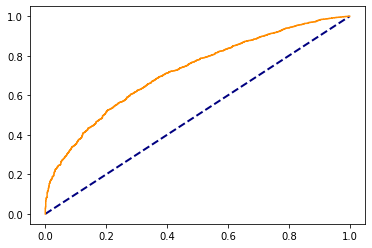

In [17]:
visualize.classification_reports(calibration_no_refit,X,y)

Using calibration improves accuracy of the final prediction but does not change AUC, but improves the accuracy. This may not be desired as the model consistently under-predicts the minority class. Retraining the calibrated model, using cross validation will refit the model. Unfortunately this has the undesired affect of applying cross validation twice. 

In [18]:
calibrated_model = CalibratedClassifierCV(model)

In [19]:
calibrated_model.fit(X_sm,y_sm)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
Fitting 7 folds for each of 12 candidates, totalling 84 fits
Fitting 7 folds for each of 12 candidates, totalling 84 fits
Fitting 7 folds for each of 12 candidates, totalling 84 fits
Fitting 7 folds for each of 12 candidates, totalling 84 fits


CalibratedClassifierCV(base_estimator=RandomizedSearchCV(cv=7,
                                                         estimator=VotingClassifier(estimators=[('rf',
                                                                                                 Pipeline(steps=[('classifier',
                                                                                                                  RandomForestClassifier(oob_score=True))])),
                                                                                                ('lr',
                                                                                                 Pipeline(steps=[('scaler',
                                                                                                                  StandardScaler()),
                                                                                                                 ('pca',
                                                                   

 class 1 :  6669
 class 0 :  1331
Confusion Matrix: 
 [[ 790  541]
 [1876 4793]]
Accuracy:  0.697875
AUC:  0.7226625451940806
              precision    recall  f1-score   support

           0       0.30      0.59      0.40      1331
           1       0.90      0.72      0.80      6669

    accuracy                           0.70      8000
   macro avg       0.60      0.66      0.60      8000
weighted avg       0.80      0.70      0.73      8000



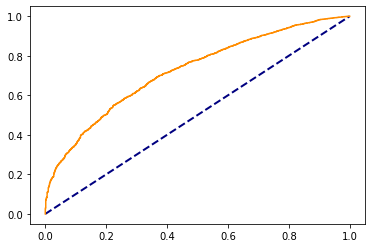

In [20]:
visualize.classification_reports(calibrated_model,X,y)

 class 1 :  6669
 class 0 :  6669
Confusion Matrix: 
 [[4867 1802]
 [1876 4793]]
Accuracy:  0.7242465137201979
AUC:  0.8108702664818551
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      6669
           1       0.73      0.72      0.72      6669

    accuracy                           0.72     13338
   macro avg       0.72      0.72      0.72     13338
weighted avg       0.72      0.72      0.72     13338



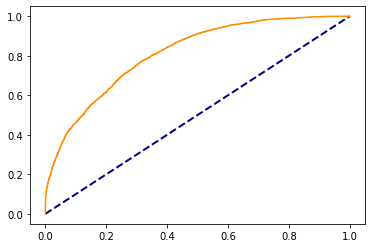

In [21]:
visualize.classification_reports(calibrated_model,X_sm,y_sm)

## Submit Predictions

In [22]:
submit_predictions.submit_predictions(calibrated_model, X_test, test_id,"SMOTE model experiment", pred_path=processed_data_dir/'12964298_week2_SMOTE.csv')

Success! User is Authenticated


100%|██████████| 88.2k/88.2k [00:05<00:00, 15.5kB/s]


,id,TARGET_5Yrs
0,0,0.611151
1,1,0.401979
2,2,0.839710
3,3,0.888121
4,4,0.302727
...,...,...
3794,3794,0.916108
3795,3795,0.592790
3796,3796,0.348514
3797,3797,0.896604


## Save Model

In [24]:
file_name = models_dir /'brackenrig_mark_12964298_week2_SMOTE.sav'
pkl.dump(calibrated_model, open(file_name, 'wb'))